<a href="https://colab.research.google.com/github/xli2522/GW-SignalGen/blob/main/fast_chirp_gw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  
#  Chirp Transform Gravitational Wave Signal Denoising
#####(for GW Signal Analysis) 
##### © Xiyuan Li 2021, Department of Physics and Astronomy, Western University (UWO), London, Ontario, Canada
##### Resources: 
[PyCBC](http://github.com/ligo-cbc/pycbc) + additional PyCBC [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html).
##### Paper Reference:
[Generalizing the inverse FFT of the unit circle, V. Sukhoy, A. Stoytchev, 2019](https://www.nature.com/articles/s41598-019-50234-9)
##### Code Reference:
[gw-odw/odw-2020](http://github.com/gw-odw/odw-2020)<br> 
[Scipy](https://docs.scipy.org/doc/scipy/reference/index.html)<br> 
[Chirp Z Transform](https://github.com/garrettj403/CZT)


In [1]:
# -- Use the following line if running in Google Colab
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'

In [2]:
# Initialization
%matplotlib inline

from pycbc.waveform import get_td_waveform
import pylab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as learn
import time
import tqdm    #progress bar

## 1 Generate GW Waveforms


### 1.1 Generate GW Waveforms using SEOBNRv4 (Example)
##### [PyCBC.waveform.getwaveform Doc](https://pycbc.org/pycbc/latest/html/pycbc.waveform.html#module-pycbc.waveform.waveform)


###### Unused parameters include spin, tidal deformability, monopole, and more.

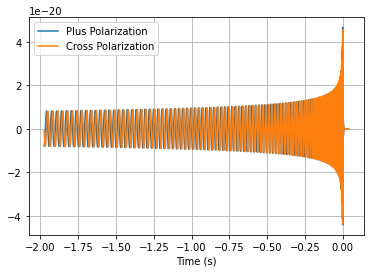

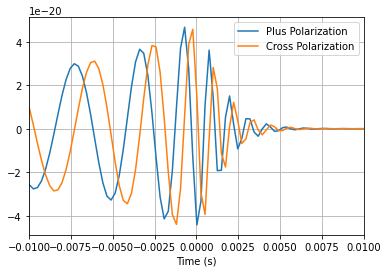

In [3]:
# Generating one example waveform 
# The output of this function are the "plus" and "cross" polarizations of the gravitational-wave signal 
# as viewed from the line of sight at a given source inclination (assumed face-on if not provided)
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/4096,
                         f_lower=30,
                         distance=5)

pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.legend()
pylab.grid()
pylab.show()

# Zoom in near the merger time#
pylab.plot(hp.sample_times, hp, label='Plus Polarization')
pylab.plot(hp.sample_times, hc, label='Cross Polarization')
pylab.xlabel('Time (s)')
pylab.xlim(-.01, .01)
pylab.legend()
pylab.grid()
pylab.show()

# verify container type and data extraction
testing_container = np.zeros(2, dtype=object)
testing_container[0], testing_container[1] = hp, hc
print(testing_container)

### 1.2 Generate N GW Waveforms using SEOBNRv4 and IMRPhenomD


#### 1.2.1 Generate Binary Mass Ratio Range

In [4]:
#Unison Shuffle if not using sklearn
def unisonShuffle(a, b):
    '''
    #testing
        a, b = unisonShuffle(np.arange(10), np.arange(10))
        print(a==b)
    '''
    rng_state = np.random.get_state()
    permu_a = np.random.shuffle(a)
    np.random.set_state(rng_state)
    permu_b = np.random.shuffle(b)

    return permu_a, permu_b

In [5]:
# Generate a set of N parameter inputs
# Upper limit: Y = X
# Lower limit: Y = .2*X 
# k parameter interval 0.1
# X range= [5, 40]
# Interval: ...

for i in range(1):              # the range determines the number of lines
  m1 = np.linspace(5, 40, 5)    # number of elements determines the number of mass elements on one line
                                    # the total number of mass points = range * elements
  m2 = (0.2+0.1*i)*m1           # the linear relationship between m1 and m2
  if i == 0:
      sum_m1 = m1
      sum_m2 = m2
  else:
      sum_m1 = np.asarray(np.concatenate((sum_m1, m1), axis=0))
      sum_m2 = np.asarray(np.concatenate((sum_m2, m2), axis=0))

np.random.seed(5625)            # set random seed for consistant result
#unisonShuffle(sum_m1, sum_m2)   # randomize for ML/NNetwork purposes

#total pairs of masses
N = len(sum_m1)
print('Total # of Masses ' + str(N))

Total # of Masses 5


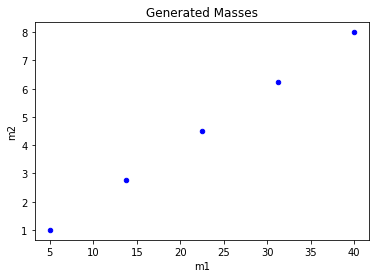

In [6]:
#Plot masses
plt.figure()
plt.scatter(sum_m1, sum_m2, color='b',s=20)
plt.xlabel('m1')
plt.ylabel('m2')
plt.title('Generated Masses')
plt.show()
plt.close()

##### 1.2.2 Generate Gravitational Wave Signal 

In [7]:
# some additional packages
# progress bar
%%capture
from tqdm import tqdm as tqdm       
tqdm().pandas()

###### Times Series Generation


In [8]:
# specify the sampling rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

In [9]:
# You can specify many parameters, 
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform
# but here, we'll use defaults for everything except the masses.
# It returns both hplus and hcross, but we'll only use hplus for now.
start_time = time.time()
generated_series = np.zeros(len(sum_m1), dtype=object)
with tqdm(total=len(sum_m1)) as pbar:
    for i in range(len(sum_m1)):
        hp1, _ = get_td_waveform(approximant=apx,
                                mass1=sum_m1[i],
                                mass2=sum_m2[i],
                                delta_t=1.0/sample_rate,
                                f_lower=25)

        # The amplitude of gravitational-wave signals is normally of order 1E-20. To demonstrate our method
        # on white noise with amplitude O(1) we normalize our signal so the cross-correlation of the signal with
        # itself will give a value of 1. In this case we can interpret the cross-correlation of the signal with white
        # noise as a signal-to-noise ratio.

        hp1 = hp1 / max(np.correlate(hp1, hp1, mode='full'))**0.5
        generated_series[i] = hp1
        pbar.update(1)

print("--- %s seconds ---" % (time.time() - start_time))
print('Generated ' +str(len(generated_series)) + ' times series.')

100%|██████████| 5/5 [00:10<00:00,  2.15s/it]

--- 10.732017993927002 seconds ---
Generated 5 times series.


### 2 Generate Noisy Signal
##### *Reference*:
[gw-odw/odw-2020](http://github.com/gw-odw/odw-2020)

In [10]:
# specify the sample rate ==> the same from above
#sample_rate = 1024 # samples per second
#data_length = 1024 # seconds

# Generate a long stretch of white noise: the data series and the time series.
data = np.random.normal(size=[sample_rate * data_length])
times = np.arange(len(data)) / float(sample_rate)

#### 2.1 Generate White Noise (Example)

Text(0, 0.5, 'Normalized amplitude')

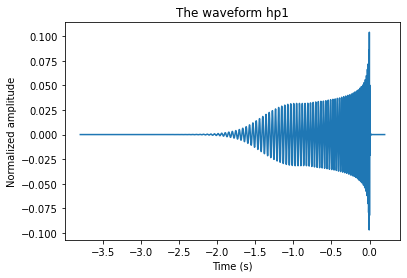

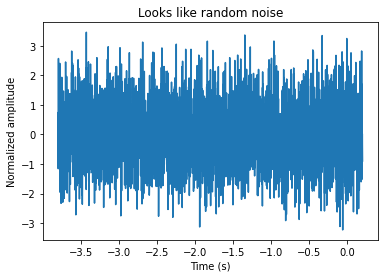

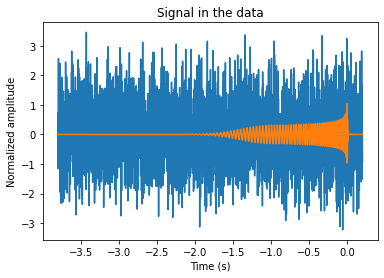

In [11]:
# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.

# take the last hp1 in memory as an example
pylab.figure()
pylab.title("The waveform hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = np.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Looks like random noise")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

#### 2.1.1 White Noise Denoising with Scipy FFT on a very short time period (Concept Testing)

##### Note: The problem with FFT and iFFT for GW signal denosing is due to the increasing frequency of BBH signal
##### **Noisy signal generationa and denoising in this section of the program is independent from the previous part - Generate White Noise

In [12]:
from scipy import fftpack
# fft legacy discrete Fourier Transform
# ifft inverse legacy discrete Fourier Transform

204
(204,)


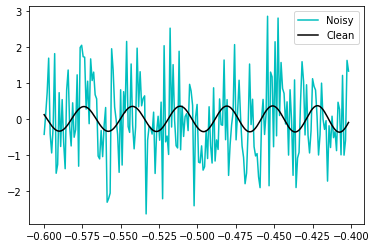

In [13]:
#load noisy data
noisy_series_FFT = data[waveform_start:waveform_start+len(hp1)]
#load normalized clean data
clean_series_FFT = list(reversed(10*hp1))
clean_series_FFT = list(reversed(clean_series_FFT))
L_FFT = int(np.floor(0.8*sample_rate))     #only take the last ? s
L2_FFT = int(np.floor(0.2*sample_rate))
print(L2_FFT)
#load time array
t_FFT = hp1.sample_times[-L_FFT:][:L2_FFT]
dt_FFT = 1/sample_rate
print(np.shape(t_FFT))


plt.figure()
plt.plot(t_FFT, noisy_series_FFT[-L_FFT:][:L2_FFT], color='c', label='Noisy')
plt.plot(t_FFT, clean_series_FFT[-L_FFT:][:L2_FFT], color='k', label='Clean')
plt.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


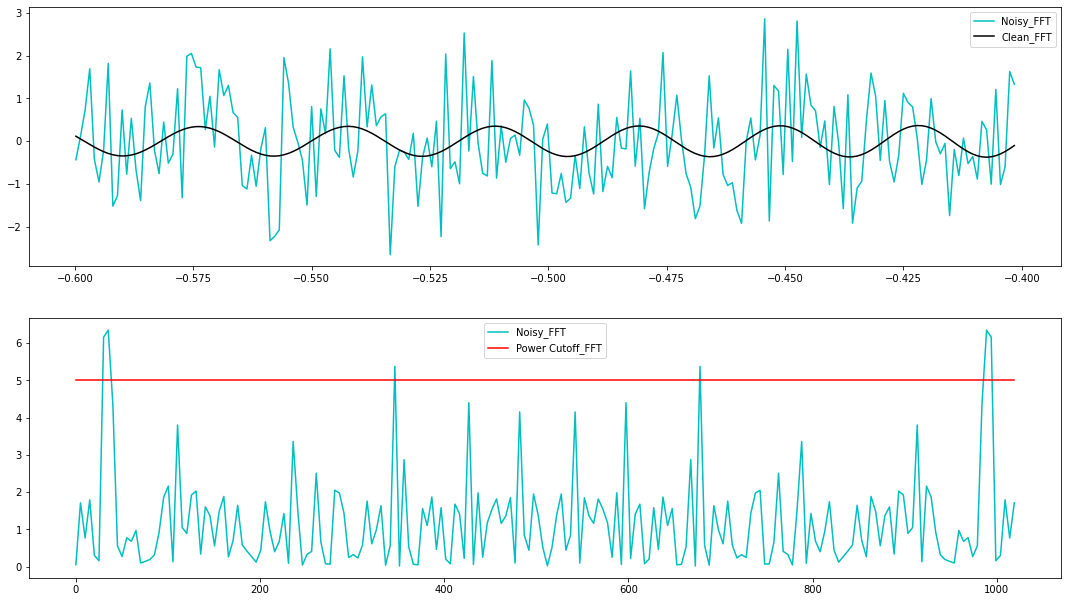

In [14]:
# start of scipy fft
n_FFT = len(t_FFT)
fhat_FFT = fftpack.fft(noisy_series_FFT[-L_FFT:], n_FFT)     #compute the fft
PSD_FFT = fhat_FFT*np.conj(fhat_FFT)/n_FFT              #compute the power spectrum
freq_FFT = (1/(dt_FFT*n_FFT))*np.arange(n_FFT)          #generate frequency axis

fig, ax = plt.subplots(2,1)

fig.set_size_inches(18.5, 10.5)

plt.sca(ax[0])
plt.plot(t_FFT, noisy_series_FFT[-L_FFT:][:L2_FFT], color='c', label='Noisy_FFT')
plt.plot(t_FFT, clean_series_FFT[-L_FFT:][:L2_FFT], color='k', label='Clean_FFT')
plt.legend()

plt.sca(ax[1])
plt.plot(freq_FFT, PSD_FFT, color='c', label='Noisy_FFT')
plt.plot(freq_FFT, np.full((L2_FFT),5),color='r', label='Power Cutoff_FFT')
plt.legend()

plt.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


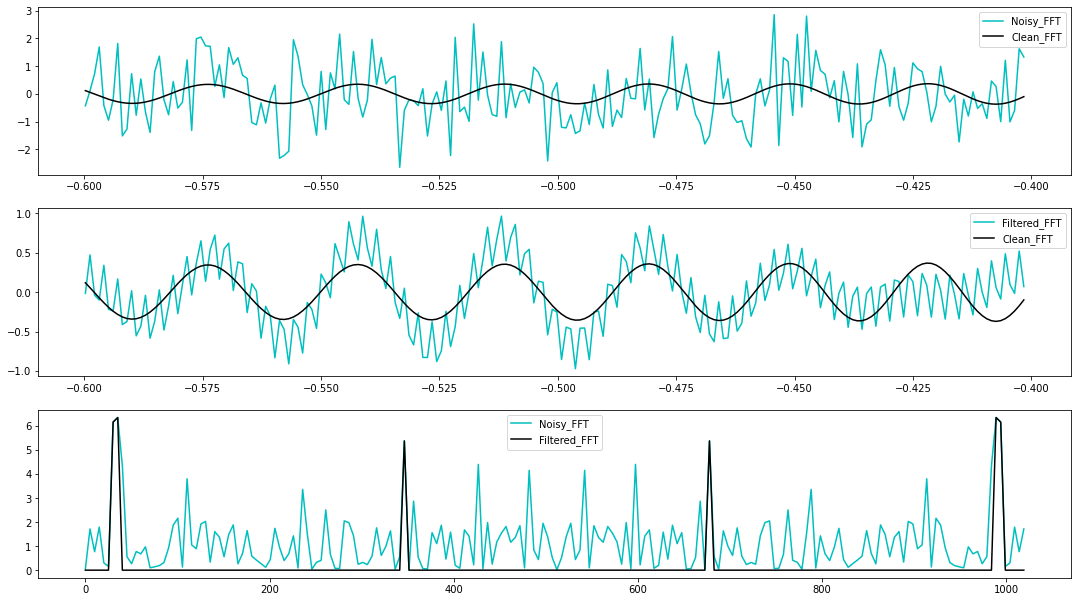

In [15]:
indices_FFT = PSD_FFT > 5
PSDclean_FFT = PSD_FFT*indices_FFT
fhat_FFT = indices_FFT*fhat_FFT
ffilt_FFT=fftpack.ifft(fhat_FFT)

fig, ax = plt.subplots(3,1)
fig.set_size_inches(18.5, 10.5)

plt.sca(ax[0])
plt.plot(t_FFT, noisy_series_FFT[-L_FFT:][:L2_FFT], color='c', label='Noisy_FFT')
plt.plot(t_FFT, clean_series_FFT[-L_FFT:][:L2_FFT], color='k', label='Clean_FFT')
plt.legend()

plt.sca(ax[1])
plt.plot(t_FFT, ffilt_FFT,color='c', label='Filtered_FFT')
plt.plot(t_FFT, clean_series_FFT[-L_FFT:][:L2_FFT], color='k', label='Clean_FFT')
plt.legend()

plt.sca(ax[2])
plt.plot(freq_FFT, PSD_FFT, color='c', label='Noisy_FFT')
plt.plot(freq_FFT, PSDclean_FFT, color='k', label='Filtered_FFT')
plt.legend()

plt.show()

#### 2.2 Generate White Noise for N Gravitational Wave Signals

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(5,)
(5,)
5632
5632


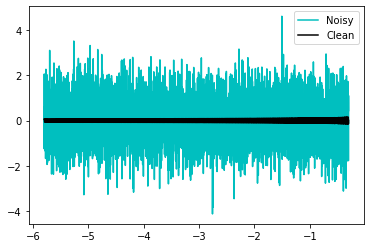

In [16]:
noisy_series = []       #np.zeros(len(generated_series))
clean_series = []       #np.zeros(len(generated_series))
t = []

# select time window between L and L2
L = int(np.floor(6*sample_rate))     #only take the last ? s ==> -?s to 0s
L2 = int(np.floor(5.5*sample_rate))  #remove the tail ==> -?s + ns 

#data = np.random.normal(size=[sample_rate * data_length])
times = np.arange(sample_rate * data_length) / float(sample_rate)     # can be reused

#load time array
#t = hp1.sample_times[-L:][:L2]
#dt = 1/sample_rate

for i in range(len(generated_series)):
    # clear data and times container every iteration
    data = np.random.normal(size=[sample_rate * data_length])

    # assign noisy data
    noisy_series.append(data[waveform_start:waveform_start + len(generated_series[i])])
    t.append(generated_series[i].sample_times[-L:][:L2])

    #load normalized clean data
    temp_clean = list(reversed(10*generated_series[i]))    # Improve: change data type for better performance
    clean_series.append(list((reversed(temp_clean))))

#check both clean and noisy signal container
print(np.shape(noisy_series)) 
print(np.shape(clean_series))

print(len(t[0]))
print(len(noisy_series[0][-L:][:L2]))
#sample the first signal
plt.figure()
plt.plot(t[0], noisy_series[0][-L:][:L2], color='c', label='Noisy')
plt.plot(t[0], clean_series[0][-L:][:L2], color='k', label='Clean')
plt.legend()

plt.show()   

